In [1017]:
import fastf1 
import pandas as pd
from fastf1 import plotting, utils
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from matplotlib.cm import viridis
from urllib.request import urlopen
import json
import requests
import numpy as np
from sklearn.linear_model import Ridge, LinearRegression, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import mean_squared_error as MSE, mean_absolute_error as MAE
import seaborn as sns
from scipy.stats.mstats import winsorize
from matplotlib.colors import LinearSegmentedColormap, to_rgba
import matplotlib.patches as mpatches

In [1018]:
# Set the option to display all columns
pd.set_option('display.max_columns', None)

## Load raw race data

In [1019]:
results = pd.read_parquet('2024_fp3_results.parquet')
results.columns

Index(['DriverNumber', 'BroadcastName', 'Abbreviation', 'DriverId', 'TeamName',
       'TeamColor', 'TeamId', 'FirstName', 'LastName', 'FullName',
       'HeadshotUrl', 'CountryCode', 'Position', 'ClassifiedPosition',
       'GridPosition', 'Q1', 'Q2', 'Q3', 'Time', 'Status', 'Points', 'Laps',
       'RoundNumber', 'Country', 'EventName', 'Season', 'MinQualiTime',
       'QualiPosition', 'LapEndTime', 'Quali_AirTemp', 'Quali_Humidity',
       'Quali_Pressure', 'Quali_Rainfall', 'Quali_TrackTemp',
       'Quali_WindDirection', 'Quali_WindSpeed', 'FP3BestLapTime',
       'FP3_AirTemp', 'FP3_TrackTemp', 'FP3_Humidity', 'FP3_Pressure',
       'FP3_Rainfall', 'FP3_WindDirection', 'FP3_WindSpeed', 'FP2BestLapTime',
       'FP2_AirTemp', 'FP2_TrackTemp', 'FP2_Humidity', 'FP2_Pressure',
       'FP2_Rainfall', 'FP2_WindDirection', 'FP2_WindSpeed'],
      dtype='object')

In [1020]:
results = results.set_index(["Season", "RoundNumber", "DriverNumber"])
results

BroadcastName Abbreviation         DriverId  \
Season RoundNumber DriverNumber                                               
2019   1           77                V BOTTAS          BOT           bottas   
                   44              L HAMILTON          HAM         hamilton   
                   33            M VERSTAPPEN          VER   max_verstappen   
                   5                 S VETTEL          VET           vettel   
                   16               C LECLERC          LEC          leclerc   
...                                       ...          ...              ...   
2024   24          20             K MAGNUSSEN          MAG  kevin_magnussen   
                   30                L LAWSON          LAW           lawson   
                   77                V BOTTAS          BOT           bottas   
                   43             F COLAPINTO          COL        colapinto   
                   11                 S PEREZ          PER            perez   

                                        TeamName TeamColor    TeamId  \
Season RoundNumber DriverNumber                                        
2019   1           77                   Mercedes    00d2be  mercedes   
                   44                   Mercedes    00d2be  mercedes   
                   33            Red Bull Racing    1e41ff  red_bull   
                   5                     Ferrari    dc0000   ferrari   
                   16                    Ferrari    dc0000   ferrari   
...                                          ...       ...       ...   
2024   24          20               Haas F1 Team    B6BABD      haas   
                   30                         RB    6692FF        rb   
                   77                Kick Sauber    52e252    sauber   
                   43                   Williams    64C4FF  williams   
                   11            Red Bull Racing    3671C6  red_bull   

                                 FirstName    LastName          FullName  \
Season RoundNumber DriverNumber                                            
2019   1           77             Valtteri      Bottas   Valtteri Bottas   
                   44                Lewis    Hamilton    Lewis Hamilton   
                   33                  Max  Verstappen    Max Verstappen   
                   5             Sebastian      Vettel  Sebastian Vettel   
                   16              Charles     Leclerc   Charles Leclerc   
...                                    ...         ...               ...   
2024   24          20                Kevin   Magnussen   Kevin Magnussen   
                   30                 Liam      Lawson       Liam Lawson   
                   77             Valtteri      Bottas   Valtteri Bottas   
                   43               Franco   Colapinto  Franco Colapinto   
                   11               Sergio       Perez      Sergio Perez   

                                                                       HeadshotUrl  \
Season RoundNumber DriverNumber                                                      
2019   1           77                                                                
                   44                                                                
                   33                                                                
                   5                                                                 
                   16                                                                
...                                                                            ...   
2024   24          20            https://media.formula1.com/d_driver_fallback_i...   
                   30                                                         None   
                   77            https://media.formula1.com/d_driver_fallback_i...   
                   43                                                         None   
                   11            https://media

In [1021]:
results = results.drop(columns=["HeadshotUrl", "CountryCode", "Country", "FirstName", "LastName", "DriverId", "BroadcastName", "Q1", "Q2", "Q3"])

In [1022]:
results

Abbreviation         TeamName TeamColor  \
Season RoundNumber DriverNumber                                           
2019   1           77                    BOT         Mercedes    00d2be   
                   44                    HAM         Mercedes    00d2be   
                   33                    VER  Red Bull Racing    1e41ff   
                   5                     VET          Ferrari    dc0000   
                   16                    LEC          Ferrari    dc0000   
...                                      ...              ...       ...   
2024   24          20                    MAG     Haas F1 Team    B6BABD   
                   30                    LAW               RB    6692FF   
                   77                    BOT      Kick Sauber    52e252   
                   43                    COL         Williams    64C4FF   
                   11                    PER  Red Bull Racing    3671C6   

                                   TeamId          FullName  Position  \
Season RoundNumber DriverNumber                                         
2019   1           77            mercedes   Valtteri Bottas       1.0   
                   44            mercedes    Lewis Hamilton       2.0   
                   33            red_bull    Max Verstappen       3.0   
                   5              ferrari  Sebastian Vettel       4.0   
                   16             ferrari   Charles Leclerc       5.0   
...                                   ...               ...       ...   
2024   24          20                haas   Kevin Magnussen      16.0   
                   30                  rb       Liam Lawson      17.0   
                   77              sauber   Valtteri Bottas      18.0   
                   43            williams  Franco Colapinto      19.0   
                   11            red_bull      Sergio Perez      20.0   

                                ClassifiedPosition  GridPosition  \
Season RoundNumber DriverNumber                                    
2019   1           77                            1           2.0   
                   44                            2           1.0   
                   33                            3           4.0   
                   5                             4           3.0   
                   16                            5           5.0   
...                                            ...           ...   
2024   24          20                           16          14.0   
                   30                           17          12.0   
                   77                            R           9.0   
                   43                            R          20.0   
                   11                            R          10.0   

                                                  Time    Status  Points  \
Season RoundNumber DriverNumber                                            
2019   1           77           0 days 01:25:27.325000  Finished    26.0   
                   44           0 days 00:00:20.886000  Finished    18.0   
                   33           0 days 00:00:22.520000  Finished    15.0   
                   5            0 days 00:00:57.109000  Finished    12.0   
                   16           0 days 00:00:58.203000  Finished    10.0   
...                                                ...       ...     ...   
2024   24          20           0 days 00:01:17.597000    Lapped     0.0   
                   30                              NaT  Finished     0.0   
                   77                              NaT   Retired     0.0   
                   43                              NaT   Retired     0.0   
                   11                              NaT   Retired     0.0   

                                 Laps              EventName  \
Season RoundNumber DriverNumber                                
2019   1           77            58.0  Australian Grand Prix   
                   44            58.0  A

## Add derived features
TODO explanation

In [1023]:
# Adding additonal features
results['FP2BestLapTime'] = results['FP2BestLapTime'].dt.total_seconds()
results['FP3BestLapTime'] = results['FP3BestLapTime'].dt.total_seconds()
results['MinQualiTime'] = results['MinQualiTime'].dt.total_seconds()

In [1024]:
best_fp2_times = results.groupby(["RoundNumber", 'Season'])[["FP2BestLapTime"]].min().rename(columns={"FP2BestLapTime": "FP2BestOverallLapTime"})
best_fp3_times = results.groupby(["RoundNumber", 'Season'])[["FP3BestLapTime"]].min().rename(columns={"FP3BestLapTime": "FP3BestOverallLapTime"})
best_quali_times = results.groupby(["RoundNumber", 'Season'])[["MinQualiTime"]].min().rename(columns={"MinQualiTime": "MinOverallQualiTime"})

In [1025]:
results = results.join(best_fp2_times).join(best_fp3_times).join(best_quali_times)

In [1026]:
# Compute driver delta from best lap time per season/race
results["FP3Delta"] = results["FP3BestLapTime"] - results["FP3BestOverallLapTime"]
results["FP2Delta"] = results["FP2BestLapTime"] - results["FP2BestOverallLapTime"]
results["QualiDelta"] = results["MinQualiTime"] - results["MinOverallQualiTime"]

In [1027]:
results['TeamFP3Delta'] = results.groupby(['Season', 'RoundNumber', 'TeamId'])['FP3Delta'].transform('mean')

# Remove missing data
As a result of crashes, injury, illness, it's possible that a given driver may not set a time in one or more of FP2/FP3/Qualifying. Regression models cannot process NaNs and there is no definitive way to impute this data, so we drop it for the purpose of training the model.

In [1028]:
results.loc[lambda df: df[["FP3BestLapTime", "MinQualiTime", "FP3Delta", "QualiDelta", 'FP2BestLapTime', 'FP2Delta']].isna().any(axis=1)].head()

Abbreviation           TeamName TeamColor  \
Season RoundNumber DriverNumber                                             
2019   3           23                    ALB         Toro Rosso    469bff   
                   99                    GIO  Alfa Romeo Racing    9b0000   
       4           7                     RAI  Alfa Romeo Racing    9b0000   
                   63                    RUS           Williams    ffffff   
                   10                    GAS    Red Bull Racing    1e41ff   

                                     TeamId            FullName  Position  \
Season RoundNumber DriverNumber                                             
2019   3           23            toro_rosso     Alexander Albon      10.0   
                   99                  alfa  Antonio Giovinazzi      15.0   
       4           7                   alfa      Kimi Räikkönen      10.0   
                   63              williams      George Russell      15.0   
                   10              red_bull        Pierre Gasly      17.0   

                                ClassifiedPosition  GridPosition Time  \
Season RoundNumber DriverNumber                                         
2019   3           23                           10           0.0  NaT   
                   99                           15          19.0  NaT   
       4           7                            10           0.0  NaT   
                   63                           15          16.0  NaT   
                   10                            R           0.0  NaT   

                                       Status  Points  Laps  \
Season RoundNumber DriverNumber                               
2019   3           23                  +1 Lap     1.0  55.0   
                   99                  +1 Lap     0.0  55.0   
       4           7                   +1 Lap     1.0  50.0   
                   63                 +2 Laps     0.0  49.0   
                   10            Transmission     0.0  38.0   

                                             EventName  MinQualiTime  \
Season RoundNumber DriverNumber                                        
2019   3           23               Chinese Grand Prix           NaN   
                   99               Chinese Grand Prix           NaN   
       4           7             Azerbaijan Grand Prix           NaN   
                   63            Azerbaijan Grand Prix       105.062   
                   10            Azerbaijan Grand Prix           NaN   

                                 QualiPosition             LapEndTime  \
Season RoundNumber DriverNumber                                         
2019   3           23                      NaN                    NaT   
                   99                      NaN 0 days 00:27:18.782000   
       4           7                      19.0 0 days 00:32:12.402000   
                   63                     17.0 0 days 00:32:14.491000   
                   10                     20.0 0 days 00:29:51.933000   

                                 Quali_AirTemp  Quali_Humidity  \
Season RoundNumber DriverNumber                                  
2019   3           23                      NaN             NaN   
                   99                     20.8            48.1   
       4           7                      16.7            67.8   
                   63                     16.7            67.8   
                   10                     16.5            68.6   

                                 Quali_Pressure  Quali_Rainfall  \
Season RoundNumber DriverNumber                                   
2019   3           23                       NaN             NaN   
                   99                    1015.9             0.0   
       4           7                     1023.5             0.0   
                   63                    1023.5             0.0   
                   10                    1023.6             0.0   

                                 Quali_TrackTemp

In [1029]:
results = results.dropna(subset=["FP3BestLapTime", "MinQualiTime", "FP3Delta", "QualiDelta", 'FP2BestLapTime', 'FP2Delta'])

# Additional features - rolling statistics
TODO explain

In [1030]:
results

Abbreviation         TeamName TeamColor  \
Season RoundNumber DriverNumber                                           
2019   1           77                    BOT         Mercedes    00d2be   
                   44                    HAM         Mercedes    00d2be   
                   33                    VER  Red Bull Racing    1e41ff   
                   5                     VET          Ferrari    dc0000   
                   16                    LEC          Ferrari    dc0000   
...                                      ...              ...       ...   
2024   24          20                    MAG     Haas F1 Team    B6BABD   
                   30                    LAW               RB    6692FF   
                   77                    BOT      Kick Sauber    52e252   
                   43                    COL         Williams    64C4FF   
                   11                    PER  Red Bull Racing    3671C6   

                                   TeamId          FullName  Position  \
Season RoundNumber DriverNumber                                         
2019   1           77            mercedes   Valtteri Bottas       1.0   
                   44            mercedes    Lewis Hamilton       2.0   
                   33            red_bull    Max Verstappen       3.0   
                   5              ferrari  Sebastian Vettel       4.0   
                   16             ferrari   Charles Leclerc       5.0   
...                                   ...               ...       ...   
2024   24          20                haas   Kevin Magnussen      16.0   
                   30                  rb       Liam Lawson      17.0   
                   77              sauber   Valtteri Bottas      18.0   
                   43            williams  Franco Colapinto      19.0   
                   11            red_bull      Sergio Perez      20.0   

                                ClassifiedPosition  GridPosition  \
Season RoundNumber DriverNumber                                    
2019   1           77                            1           2.0   
                   44                            2           1.0   
                   33                            3           4.0   
                   5                             4           3.0   
                   16                            5           5.0   
...                                            ...           ...   
2024   24          20                           16          14.0   
                   30                           17          12.0   
                   77                            R           9.0   
                   43                            R          20.0   
                   11                            R          10.0   

                                                  Time    Status  Points  \
Season RoundNumber DriverNumber                                            
2019   1           77           0 days 01:25:27.325000  Finished    26.0   
                   44           0 days 00:00:20.886000  Finished    18.0   
                   33           0 days 00:00:22.520000  Finished    15.0   
                   5            0 days 00:00:57.109000  Finished    12.0   
                   16           0 days 00:00:58.203000  Finished    10.0   
...                                                ...       ...     ...   
2024   24          20           0 days 00:01:17.597000    Lapped     0.0   
                   30                              NaT  Finished     0.0   
                   77                              NaT   Retired     0.0   
                   43                              NaT   Retired     0.0   
                   11                              NaT   Retired     0.0   

                                 Laps              EventName  MinQualiTime  \
Season RoundNumber DriverNumber                                              
2019   1           77            58.0  Australian Grand Prix        80.598  

In [1031]:
r2 = results[['QualiDelta', 'FP3Delta', 'TeamId']].copy().reset_index()
r2['RoundNumber'] = r2['RoundNumber'] + 1
# Calculate mean of the Qualifying delta for each driver from the previous 1-5 rounds
r2['Prev5QualiDeltas'] = (
    r2.groupby(['DriverNumber', 'Season'])['QualiDelta']
      .transform(lambda x: x.shift().rolling(5, min_periods=1).mean())
)

In [1032]:
r2['TeamPrevQualiDelta'] = r2.groupby(['Season', 'RoundNumber', 'TeamId'])['QualiDelta'].transform('mean')
r2 = r2.rename(columns={'QualiDelta': 'PrevQualiDelta'})

In [1033]:
results = results.join(r2.set_index(['DriverNumber', 'RoundNumber', 'Season']).drop(columns=["TeamId", "FP3Delta"]))

In [1034]:
# For the first race of the season there will be no prior data (or there is a stand-in driver). Substitute FP3 delta
results["PrevQualiDelta"] = results["PrevQualiDelta"].fillna(results['FP3Delta'])
results["Prev5QualiDeltas"] = results["Prev5QualiDeltas"].fillna(results['FP3Delta'])
results["TeamPrevQualiDelta"] = results["TeamPrevQualiDelta"].fillna(results['TeamFP3Delta'])

## Clean data and handle outliers
TODO explain why you need to clip deltas
Why are the deltas so large?

In [1035]:
cols = ['FP3Delta', 'FP2Delta', 'QualiDelta', 'Prev5QualiDeltas', 'PrevQualiDelta', 'TeamFP3Delta', 'TeamPrevQualiDelta']

In [1036]:
results[(results[cols] > 4).any(axis=1)]

Abbreviation      TeamName TeamColor  \
Season RoundNumber DriverNumber                                        
2019   1           88                    KUB      Williams    ffffff   
       2           63                    RUS      Williams    ffffff   
                   88                    KUB      Williams    ffffff   
       3           88                    KUB      Williams    ffffff   
       4           18                    STR  Racing Point    f596c8   
...                                      ...           ...       ...   
2024   22          43                    COL      Williams    64C4FF   
                   18                    STR  Aston Martin    229971   
                   77                    BOT   Kick Sauber    52e252   
                   23                    ALB      Williams    64C4FF   
                   10                    GAS        Alpine    0093cc   

                                       TeamId          FullName  Position  \
Season RoundNumber DriverNumber                                             
2019   1           88                williams     Robert Kubica      17.0   
       2           63                williams    George Russell      15.0   
                   88                williams     Robert Kubica      16.0   
       3           88                williams     Robert Kubica      17.0   
       4           18            racing_point      Lance Stroll       9.0   
...                                       ...               ...       ...   
2024   22          43                williams  Franco Colapinto      14.0   
                   18            aston_martin      Lance Stroll      15.0   
                   77                  sauber   Valtteri Bottas      18.0   
                   23                williams   Alexander Albon      19.0   
                   10                  alpine      Pierre Gasly      20.0   

                                ClassifiedPosition  GridPosition  \
Season RoundNumber DriverNumber                                    
2019   1           88                           17          20.0   
       2           63                           15          19.0   
                   88                           16          20.0   
       3           88                           17          18.0   
       4           18                            9          13.0   
...                                            ...           ...   
2024   22          43                           14          20.0   
                   18                           15          18.0   
                   77                           18          19.0   
                   23                            R          17.0   
                   10                            R           3.0   

                                                  Time    Status  Points  \
Season RoundNumber DriverNumber                                            
2019   1           88                              NaT   +3 Laps     0.0   
       2           63                              NaT    +1 Lap     0.0   
                   88                              NaT   +2 Laps     0.0   
       3           88                              NaT   +2 Laps     0.0   
       4           18           0 days 00:01:43.816000  Finished     2.0   
...                                                ...       ...     ...   
2024   22          43           0 days 00:01:15.172000  Finished     0.0   
                   18           0 days 00:01:24.102000  Finished     0.0   
                   77           0 days 00:00:11.285000    Lapped     0.0   
                   23                              NaT   Retired     0.0   
                   10                              NaT   Retired     0.0   

                                 Laps              EventName  MinQualiTime  \
Season RoundNumber DriverNumber                                              
2019   1           88            55.0  Australian Grand Prix   

In [1037]:
results[cols] = results.groupby(['Season', 'RoundNumber'])[cols].transform(lambda x: x.clip(upper=4))

In [1038]:
results['Quali_Rainfall'] = results['Quali_Rainfall'].fillna(0).astype(int)
results['FP3_Rainfall']   = results['FP3_Rainfall'].fillna(0).astype(int)

In [1039]:
results.to_parquet("qualifying_data_with_training_features.parquet")

## Build a rolling model
Create a model that predicts qualifying delta trained on previous race data that uses only FP2/FP3 as inputs from the current race prediction.

In [1060]:
results.index[0]

(np.int64(1), '1', np.int64(2024))

In [1107]:
# Feature columns
x_cols = [
    'FP3Delta', 'Prev5QualiDeltas', 'FP2Delta',
    'PrevQualiDelta', 'TeamFP3Delta', 'TeamPrevQualiDelta'
]

# Seasons and storage setup
season = 2024
models = {}
model_stats = []
all_data = []

# Loop over each race in the 2024 season
for race_number in range(1, 23):
    # Historical data
    historic_data = results.loc[
        lambda df: (df.index.get_level_values("Season") < season)
        | (
            (df.index.get_level_values("Season") == season)
            & (df.index.get_level_values("RoundNumber") < race_number)
        )
    ].copy()

    # Current race data
    current_data = results.loc[
        lambda df: (
            (df.index.get_level_values("Season") == season)
            & (df.index.get_level_values("RoundNumber") == race_number)
        )
    ].copy()

    # Skip if no data available
    if historic_data.empty or current_data.empty:
        continue

    # Fit Lasso regression model
    # model = LinearRegression().fit(historic_data[x_cols], historic_data["QualiPosition"])
    model = Lasso(alpha=1).fit(historic_data[x_cols], historic_data["QualiPosition"])

    # Predict qualifying deltas and derive predicted positions
    predicted_delta = model.predict(current_data[x_cols])
    predicted_qualifying_positions = predicted_delta.argsort() + 1
    current_data["PredictedQualiPosition"] = predicted_qualifying_positions

    # Compute MAE for the current race
    mae_value = MAE(
        current_data["QualiPosition"],
        current_data["PredictedQualiPosition"]
    )

    # Store model statistics
    model_entry = {
        "Season": season,
        "RoundNumber": race_number,
        "r2_score": model.score(
            historic_data[x_cols], historic_data["QualiPosition"]
        ),
        "MAE": mae_value,
    }

    # Add model coefficients for traceability
    model_entry.update(dict(zip(x_cols, model.coef_)))

    # Append all results
    model_stats.append(model_entry)
    all_data.append(current_data)
    models[race_number] = model

# Combine all collected race data and model stats
all_data = pd.concat(all_data)
model_stats = pd.DataFrame(model_stats)


In [1106]:
all_data

Abbreviation         TeamName TeamColor  \
RoundNumber DriverNumber Season                                           
2           1            2024            VER  Red Bull Racing    3671c6   
            11           2024            PER  Red Bull Racing    3671c6   
            16           2024            LEC          Ferrari    e8002d   
            81           2024            PIA          McLaren    ff8000   
            14           2024            ALO     Aston Martin    229971   
...                                      ...              ...       ...   
22          30           2024            LAW               RB    6692FF   
            31           2024            OCO           Alpine    0093cc   
            77           2024            BOT      Kick Sauber    52e252   
            23           2024            ALB         Williams    64C4FF   
            10           2024            GAS           Alpine    0093cc   

                                       TeamId         FullName  Position  \
RoundNumber DriverNumber Season                                            
2           1            2024        red_bull   Max Verstappen       1.0   
            11           2024        red_bull     Sergio Perez       2.0   
            16           2024         ferrari  Charles Leclerc       3.0   
            81           2024         mclaren    Oscar Piastri       4.0   
            14           2024    aston_martin  Fernando Alonso       5.0   
...                                       ...              ...       ...   
22          30           2024              rb      Liam Lawson      16.0   
            31           2024          alpine     Esteban Ocon      17.0   
            77           2024          sauber  Valtteri Bottas      18.0   
            23           2024        williams  Alexander Albon      19.0   
            10           2024          alpine     Pierre Gasly      20.0   

                                ClassifiedPosition  GridPosition  \
RoundNumber DriverNumber Season                                    
2           1            2024                    1           1.0   
            11           2024                    2           3.0   
            16           2024                    3           2.0   
            81           2024                    4           5.0   
            14           2024                    5           4.0   
...                                            ...           ...   
22          30           2024                   16          14.0   
            31           2024                   17          11.0   
            77           2024                   18          19.0   
            23           2024                    R          17.0   
            10           2024                    R           3.0   

                                                  Time    Status  Points  \
RoundNumber DriverNumber Season                                            
2           1            2024   0 days 01:20:43.273000  Finished    25.0   
            11           2024   0 days 00:00:13.643000  Finished    18.0   
            16           2024   0 days 00:00:18.639000  Finished    16.0   
            81           2024   0 days 00:00:32.007000  Finished    12.0   
            14           2024   0 days 00:00:35.759000  Finished    10.0   
...                                                ...       ...     ...   
22          30           2024   0 days 00:01:31.005000  Finished     0.0   
            31           2024   0 days 00:00:02.060000    Lapped     0.0   
            77           2024   0 days 00:00:11.285000    Lapped     0.0   
            23           2024                      NaT   Retired     0.0   
            10           2024                      NaT   Retired     0.0   

                                 Laps                 EventName  MinQualiTime  \
RoundNumber DriverNumber Season                                                 
2           1            2024  

<Axes: xlabel='Season,RoundNumber'>

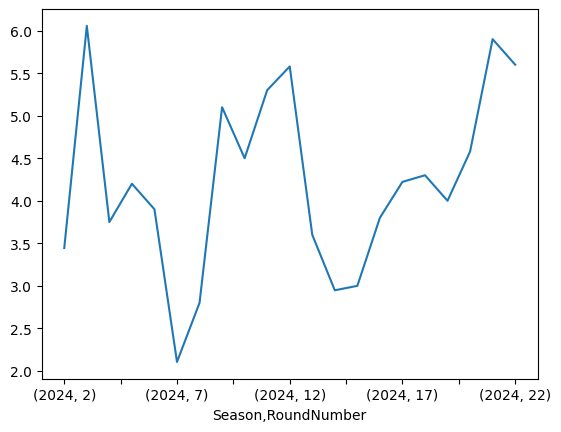

In [1094]:
all_data.groupby(["Season", "RoundNumber"]).apply(lambda x: MAE(x["QualiPosition"], x["PredictedQualiPosition"])).plot()

<Axes: xlabel='Season,RoundNumber'>

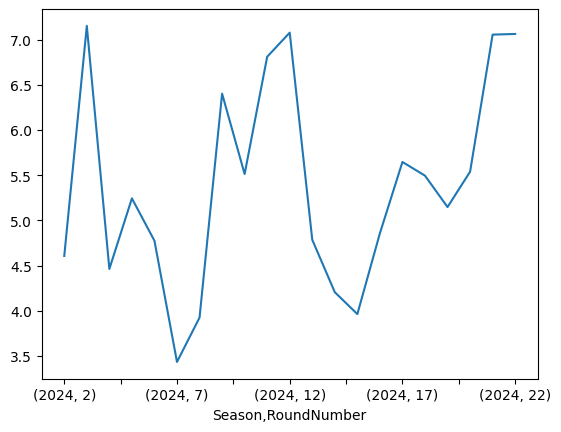

In [1095]:
all_data.groupby(["Season", "RoundNumber"]).apply(lambda x: MSE(x["QualiPosition"], x["PredictedQualiPosition"])**0.5).plot()

In [1096]:
model_stats.sort_values('MAE').head(20)

,Season,RoundNumber,r2_score,MAE,FP3Delta,Prev5QualiDeltas,FP2Delta,PrevQualiDelta,TeamFP3Delta,TeamPrevQualiDelta
5,2024,7,0.563993,2.105263,1.074100,1.310561e+00,0.000000,2.451234,0.000000,0.0
6,2024,8,0.561852,2.800000,1.670546,7.218305e-01,0.000000,2.521450,0.000000,0.0
12,2024,14,0.488095,2.947368,1.302689,1.603671e+00,0.000000,1.434786,0.000000,0.0
13,2024,15,0.411085,3.000000,0.696857,1.732730e+00,0.000000,1.317526,0.000000,0.0
0,2024,2,0.685268,3.444444,6.530257,1.786917e-15,0.292420,0.000000,0.000000,0.0
11,2024,13,0.496431,3.600000,1.272998,1.528556e+00,0.000000,1.621383,0.000000,0.0
2,2024,4,0.656328,3.750000,1.252276,0.000000e+00,0.000000,4.453067,0.000000,0.0
14,2024,16,0.407346,3.800000,0.406591,2.110731e+00,0.044952,1.158621,0.000000,0.0
4,2024,6,0.591951,3.900000,1.689485,0.000000e+00,0.000000,3.297139,0.000000,0.0
17,2024,19,0.412520,4.000000,0.555408,1.750824e+00,0.171706,1.243022,0.000000,0.0


In [1097]:
model_stats["MAE"].mean()

np.float64(4.222988025619604)

<Axes: >

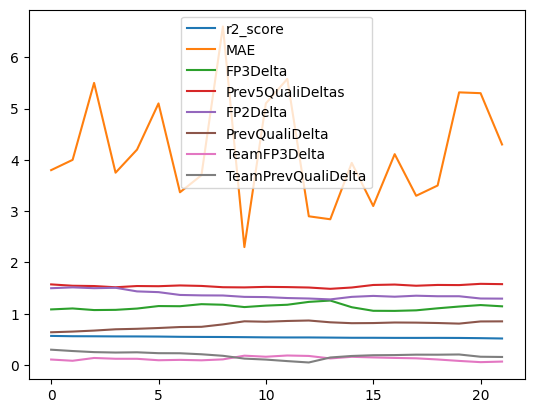

In [1098]:
lr_model_stats.loc[:, (model_stats.columns != 'Season') & (model_stats.columns != 'RoundNumber')].plot()

<Axes: >

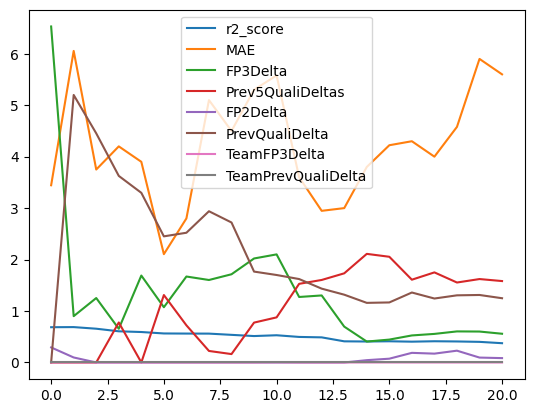

In [1088]:
model_stats.loc[:, (model_stats.columns != 'Season') & (model_stats.columns != 'RoundNumber')].plot()

In [1089]:
# Compute MAE per event
mae_per_event = all_data.groupby(['Season', 'RoundNumber']).apply(
    lambda df: MAE(df['QualiPosition'], df['PredictedQualiPosition'])
).reset_index(name='MAE')

mae_per_event = mae_per_event.sort_values('MAE')
print(mae_per_event)

# Global MAE across all predictions
global_mae = MAE(all_data['QualiPosition'], all_data['PredictedQualiPosition'])
print(f"Global MAE: {global_mae:.3f}")

# Preview predictions
print(all_data[['QualiPosition', 'PredictedQualiPosition']].head())

    Season  RoundNumber       MAE
5     2024            7  2.105263
6     2024            8  2.800000
12    2024           14  2.947368
13    2024           15  3.000000
0     2024            2  3.444444
11    2024           13  3.600000
2     2024            4  3.750000
14    2024           16  3.800000
4     2024            6  3.900000
17    2024           19  4.000000
3     2024            5  4.200000
15    2024           17  4.222222
16    2024           18  4.300000
8     2024           10  4.500000
18    2024           20  4.578947
7     2024            9  5.100000
9     2024           11  5.300000
10    2024           12  5.578947
20    2024           22  5.600000
19    2024           21  5.900000
1     2024            3  6.055556
Global MAE: 4.241
                                 QualiPosition  PredictedQualiPosition
RoundNumber DriverNumber Season                                       
2           1            2024              1.0                       1
            11       

# A visualization of deltas throughout a season
This is shown to make sure at atleast one driver has a quali delta of 0 every race and to analyse outlier races which have many Deltas that have been capped to 4

<Axes: xlabel='RoundNumber', ylabel='QualiDelta'>

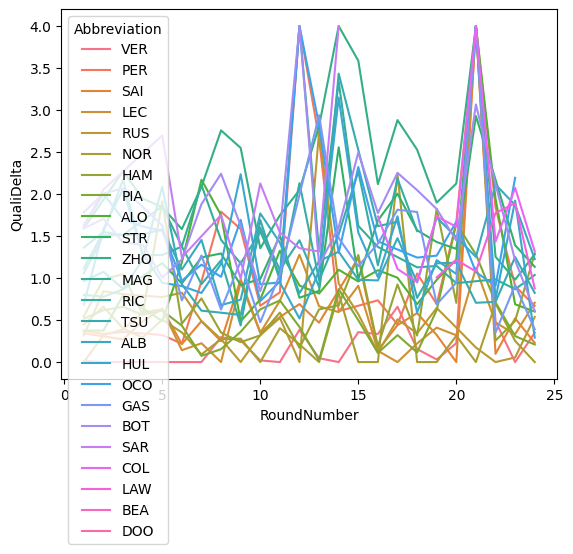

In [1040]:
subset = results.loc[results.index.get_level_values('Season') == 2024]
sns.lineplot(
    x=subset.index.get_level_values('RoundNumber'),
    y=subset['QualiDelta'],
    hue=subset['Abbreviation'],
    errorbar=None
)


In [1041]:
corr = results['TeamFP3Delta'].corr(results['FP3Delta'])
print(corr)

0.9326347174000844


# Correlations between features
I have plotted the correlations between the quali delta and all of my features to make sure they are all relevant to my prediction.

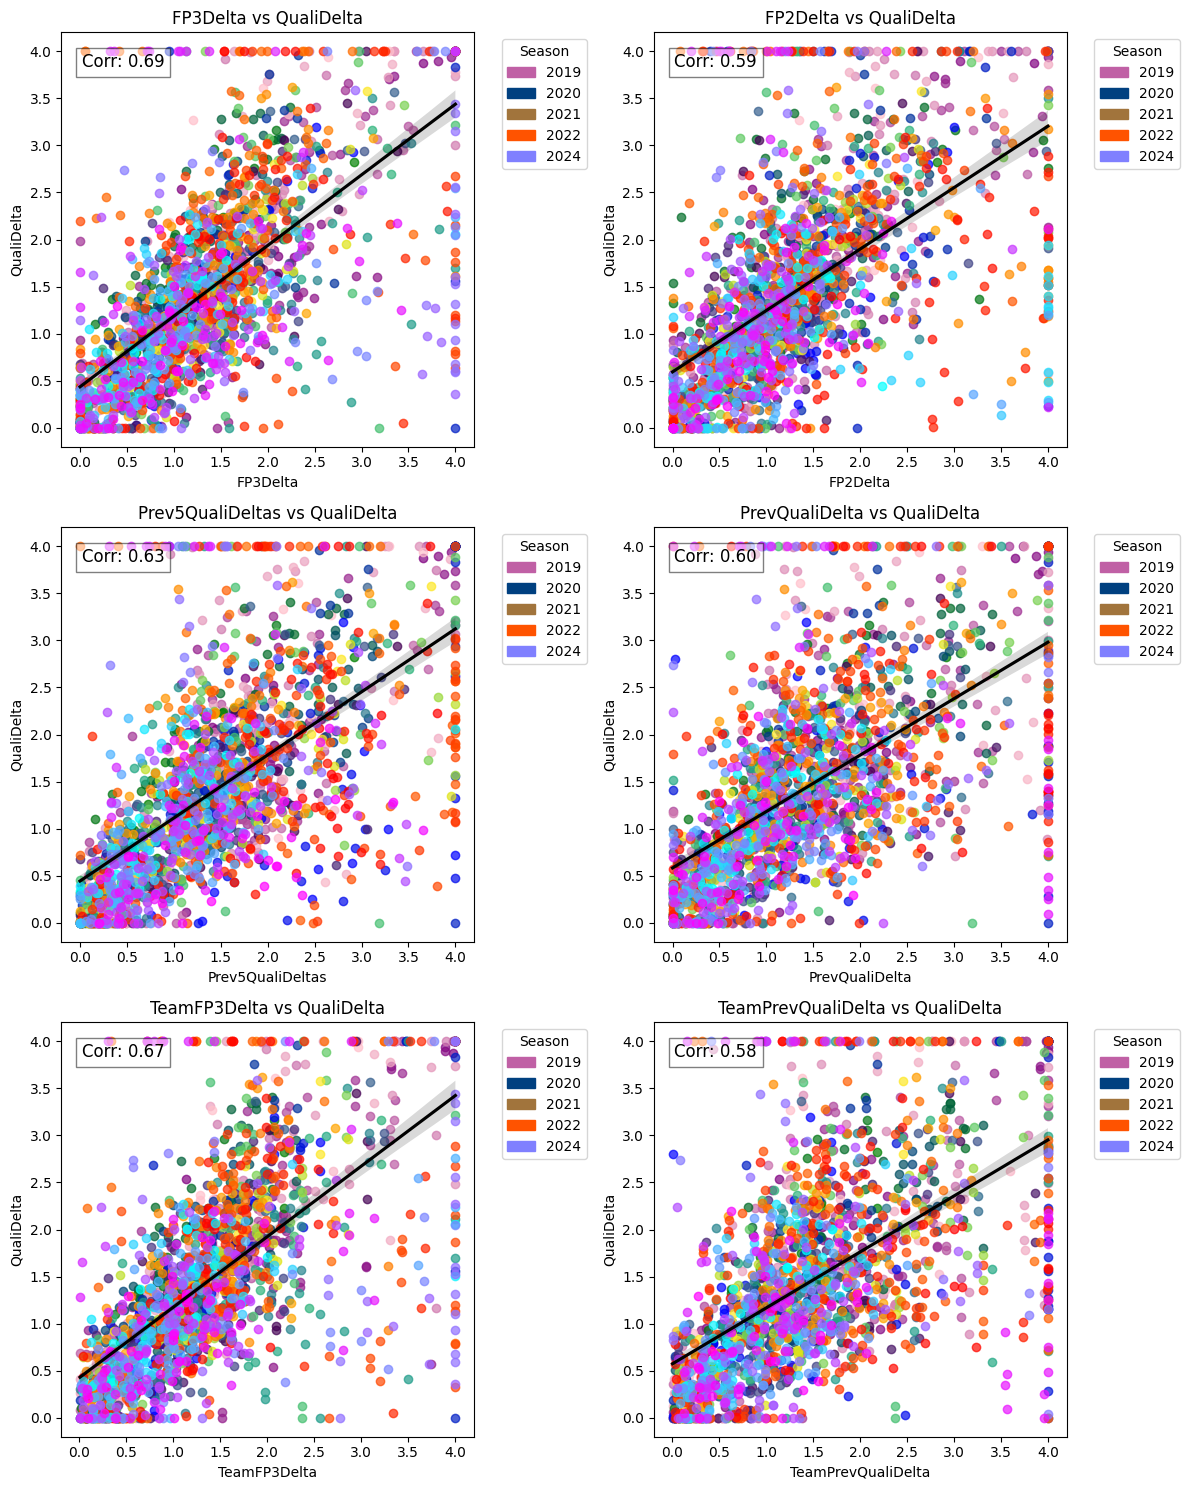

In [1042]:
results = results.reset_index()
results = results.drop_duplicates(subset=['Season', 'RoundNumber', 'DriverNumber']).set_index(['Season', 'RoundNumber', 'DriverNumber'])

# Define custom colormaps for specific seasons
season_cmaps = {
    2019: LinearSegmentedColormap.from_list("purple_pink", ["purple", "pink"]),
    2020: LinearSegmentedColormap.from_list("green_blue", ["green", "blue"]),
    2022: LinearSegmentedColormap.from_list("orange_red", ["orange", "red"]),
    2024: LinearSegmentedColormap.from_list("cyan_magenta", ["cyan", "magenta"]),
}

# Prepare plots
fig, axes = plt.subplots(3, 2, figsize=(12, 15))
plots_info = [
    ('FP3Delta', axes[0, 0], 'FP3Delta vs QualiDelta'),
    ('FP2Delta', axes[0, 1], 'FP2Delta vs QualiDelta'),
    ('Prev5QualiDeltas', axes[1, 0], 'Prev5QualiDeltas vs QualiDelta'),
    ('PrevQualiDelta', axes[1, 1], 'PrevQualiDelta vs QualiDelta'),
    ('TeamFP3Delta', axes[2, 0], 'TeamFP3Delta vs QualiDelta'),
    ('TeamPrevQualiDelta', axes[2, 1], 'TeamPrevQualiDelta vs QualiDelta')
]

# Extract unique seasons from index level
sorted_seasons = sorted(results.index.get_level_values('Season').unique())

for x_col, ax, title in plots_info:
    for season in sorted_seasons:
        # Select data for one season
        season_data = results.loc[season]

        # Get unique rounds for this season
        unique_rounds = sorted(season_data.index.get_level_values('RoundNumber').unique())
        cmap = season_cmaps.get(season, plt.cm.viridis)
        colors = cmap(np.linspace(0, 1, len(unique_rounds)))
        round_color_mapping = {round_num: color for round_num, color in zip(unique_rounds, colors)}

        # Plot each round
        for round_num in unique_rounds:
            subset = season_data.loc[round_num]
            ax.scatter(subset[x_col], subset['QualiDelta'],
                       color=round_color_mapping[round_num],
                       alpha=0.7)

    # Regression line (works fine with MultiIndex)
    sns.regplot(
        x=results[x_col],
        y=results['QualiDelta'],
        ax=ax,
        scatter=False,
        color='black'
    )

    # Correlation text
    corr = results[x_col].corr(results['QualiDelta'])
    ax.set_title(title)
    ax.text(0.05, 0.95, f'Corr: {corr:.2f}', transform=ax.transAxes,
            verticalalignment='top', fontsize=12, bbox=dict(facecolor='white', alpha=0.5))

    # Custom legend: only one patch per season
    season_patches = []
    for season in sorted_seasons:
        cmap = season_cmaps.get(season, plt.cm.viridis)
        color_start = to_rgba(cmap(0.0))
        color_end = to_rgba(cmap(1.0))
        mid_color = tuple(np.mean([color_start[:3], color_end[:3]], axis=0))
        season_patches.append(mpatches.Patch(color=mid_color, label=str(season)))

    ax.legend(handles=season_patches, title="Season",
              bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)

plt.tight_layout()
plt.show()

## Inter Feature correlation
TODO explain how highly correlated features are a problem

<Axes: >

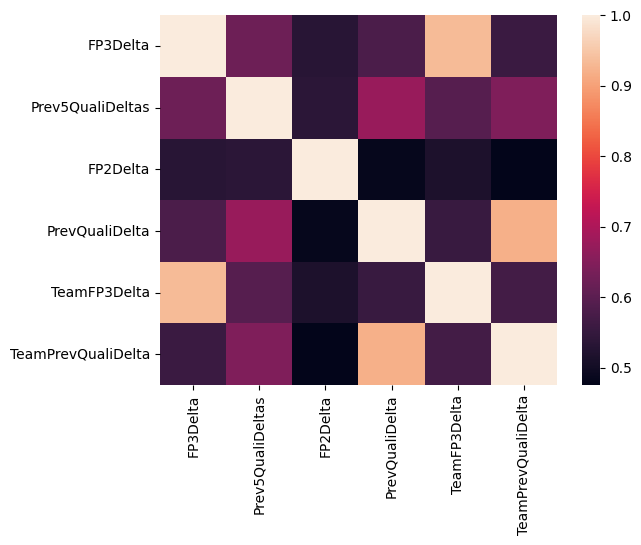

In [1043]:
# calculate the correlation matrix on the numeric columns
corr = results[['FP3Delta', 'Prev5QualiDeltas', 'FP2Delta', 'PrevQualiDelta', 'TeamFP3Delta', 'TeamPrevQualiDelta']].select_dtypes('number').corr()

# plot the heatmap
sns.heatmap(corr)

# Cutting the data
## Track Temperature
By cutting my data by track temperature we can see that as temperature decreases the correlation between the FP3 Delta and the Qualifying Delta also decreases. This is because when the track is very cold in Qualifying it means there is a high different between the track temperature in FP3 and Qualifying causing the correlation to be lower. Because i want to keep the model generalized so i can work with any data and wont have to have poorer results for rookies or stand in drivers.

If i was to use driver profiles, the way i would do it is to take the 

/tmp/ipykernel_3345625/1779145202.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  results.groupby('Quali_TrackTempBin')[['QualiDelta', 'FP3Delta']]


Quali_TrackTempBin            
Cool (<24°C)        QualiDelta    0.464804
Mild (24-32°C)      QualiDelta    0.663977
Warm (32-40°C)      QualiDelta    0.807194
Hot (>40°C)         QualiDelta    0.808828
Name: FP3Delta, dtype: float64


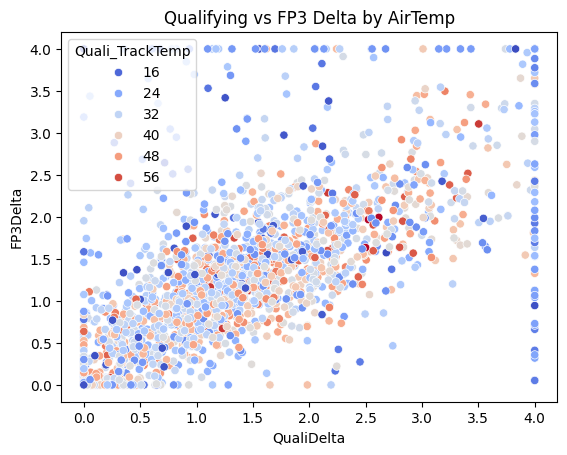

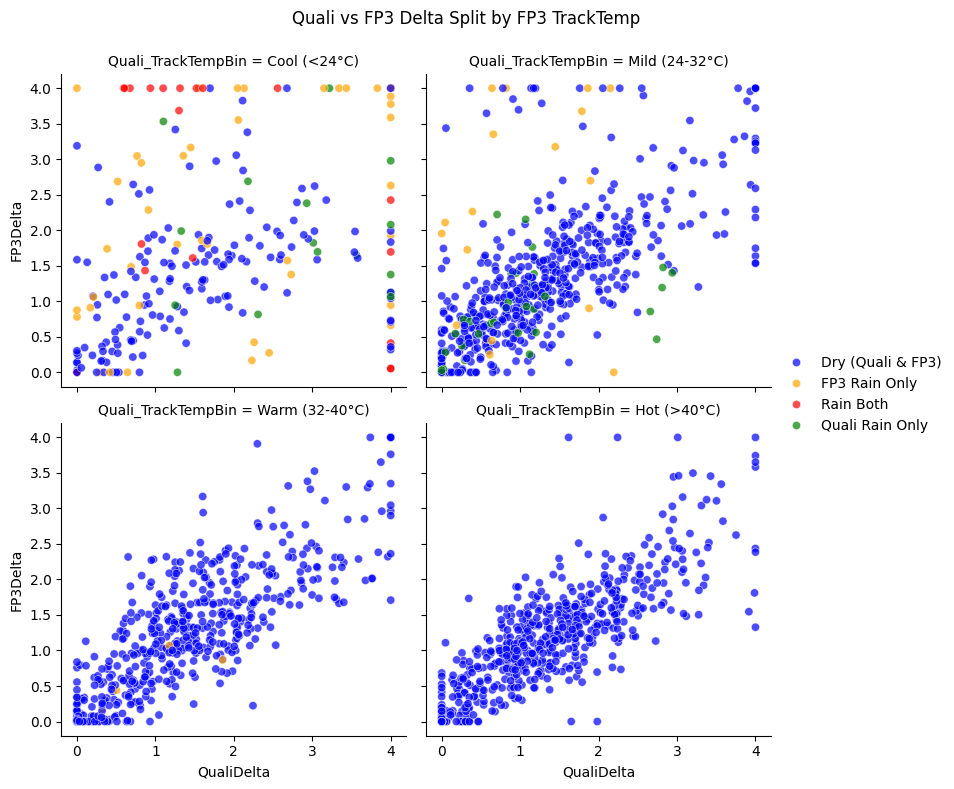

In [1044]:
results['Quali_TrackTempBin'] = pd.cut(
    results['Quali_TrackTemp'],
    bins=[-float('inf'), 24, 32, 40, float('inf')],
    labels=['Cool (<24°C)', 'Mild (24-32°C)', 'Warm (32-40°C)', 'Hot (>40°C)']
)
# Binary columns for rain

# Combine into one categorical column
def rain_category(row):
    if not row['Quali_Rainfall'] and not row['FP3_Rainfall']:
        return 'Dry (Quali & FP3)'
    elif not row['Quali_Rainfall'] and row['FP3_Rainfall']:
        return 'FP3 Rain Only'
    elif row['Quali_Rainfall'] and not row['FP3_Rainfall']:
        return 'Quali Rain Only'
    else:
        return 'Rain Both'

results['RainCategory'] = results.apply(rain_category, axis=1)

corrs = (
    results.groupby('Quali_TrackTempBin')[['QualiDelta', 'FP3Delta']]
    .corr()
    .iloc[0::2, -1]  # extract correlation between the two variables
)
print(corrs)


sns.scatterplot(
    data=results,
    x='QualiDelta',
    y='FP3Delta',
    hue='Quali_TrackTemp',
    palette='coolwarm'
)
plt.title("Qualifying vs FP3 Delta by AirTemp")

palette = {
    'Dry (Quali & FP3)': 'blue',
    'FP3 Rain Only': 'orange',
    'Quali Rain Only': 'green',
    'Rain Both': 'red'
}

g = sns.FacetGrid(results, col='Quali_TrackTempBin', col_wrap=2, height=4)
g.map_dataframe(
    sns.scatterplot,
    x='QualiDelta',
    y='FP3Delta',
    hue='RainCategory',
    palette=palette,
    alpha=0.7
)
g.add_legend()
plt.subplots_adjust(top=0.9)
g.fig.suptitle("Quali vs FP3 Delta Split by FP3 TrackTemp")
plt.show()


plt.show()


In [1045]:
X = results[['FP3Delta', 'Prev5QualiDeltas', 'FP2Delta', 'PrevQualiDelta', 'TeamFP3Delta', 'TeamPrevQualiDelta']]
y = results['QualiDelta']
print(len(X))
print(len(y))

1946
1946


In [1046]:
# groups = results.index.get_level_values('RoundNumber')  # This ensures all rows of the same race stay together

# # Define the splitter
# gss = GroupShuffleSplit(n_splits=2, test_size=0.2, random_state=2)

# # Perform the split
# train_idx, test_idx = next(gss.split(X, y, groups=groups))
# X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
# y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
# Split by chronological order instead of random
# Define feature and target columns
X = results[['FP3Delta', 'Prev5QualiDeltas', 'FP2Delta',
             'PrevQualiDelta', 'TeamFP3Delta', 'TeamPrevQualiDelta']]
y = results['QualiDelta']

# Define train/test split by season
train_mask = results.index.get_level_values('Season') < 2024
test_mask = results.index.get_level_values('Season') == 2024

# Apply masks
X_train, X_test = X[train_mask], X[test_mask]
y_train, y_test = y[train_mask], y[test_mask]



In [1047]:
X_train

FP3Delta  Prev5QualiDeltas  FP2Delta  \
Season RoundNumber DriverNumber                                         
2019   1           77               1.130            1.1300     0.048   
                   44               0.000            0.0000     0.000   
                   33               1.189            1.1890     0.800   
                   5                0.264            0.2640     0.873   
                   16               0.457            0.4570     1.154   
...                                   ...               ...       ...   
2022   22          47               1.491            2.8558     1.693   
                   20               1.374            2.3214     1.769   
                   44               0.240            0.6548     0.615   
                   6                1.664            3.8066     2.116   
                   14               1.094            1.1912     0.897   

                                 PrevQualiDelta  TeamFP3Delta  \
Season RoundNumber DriverNumber                                 
2019   1           77                     1.130        0.5650   
                   44                     0.000        0.5650   
                   33                     1.189        1.1320   
                   5                      0.264        0.3605   
                   16                     0.457        0.3605   
...                                         ...           ...   
2022   22          47                     4.000        1.4325   
                   20                     0.529        1.4325   
                   44                     0.658        0.3265   
                   6                      4.000        1.3665   
                   14                     0.513        1.0925   

                                 TeamPrevQualiDelta  
Season RoundNumber DriverNumber                      
2019   1           77                        0.5650  
                   44                        0.5650  
                   33                        1.1320  
                   5                         0.3605  
                   16                        0.3605  
...                                             ...  
2022   22          47                        3.0045  
                   20                        3.0045  
                   44                        0.5475  
                   6                         2.4820  
                   14                        0.6095  

[1487 rows x 6 columns]

In [1048]:
model = Lasso(alpha=1).fit(X_train, y_train)
lr_y_pred = lr.predict(X_test)

rf = RandomForestRegressor()
rf.fit(X_train, y_train)
rf_y_pred = rf.predict(X_test)

# lr = LinearRegression()
# lr.fit(X, y)
# lr_y_pred = lr.predict(X)

# rf = RandomForestRegressor()
# rf.fit(X, y)
# rf_y_pred = rf.predict(X)


In [1049]:
xx = X_test.copy().drop(columns=x_cols)
y_pred = [(a + b) / 2 for a, b in zip(lr_y_pred, rf_y_pred)]
xx["prediction"] = lr_y_pred
print(xx['prediction'])
xx.reset_index()
results

# xx = X.copy().drop(columns=x_cols)
# y_pred = [(a + b) / 2 for a, b in zip(lr_y_pred, rf_y_pred)]
# xx["prediction"] = y_pred
# print(xx['prediction'])
# xx.reset_index()
# results

Season  RoundNumber  DriverNumber
2024    1            1               0.379517
                     11              0.542759
                     55              0.185336
                     16              0.412370
                     63              0.419655
                                       ...   
        24           20              0.885440
                     30              1.260831
                     77              1.227505
                     43              1.805977
                     11              1.071614
Name: prediction, Length: 459, dtype: float64


Abbreviation         TeamName TeamColor  \
Season RoundNumber DriverNumber                                           
2019   1           77                    BOT         Mercedes    00d2be   
                   44                    HAM         Mercedes    00d2be   
                   33                    VER  Red Bull Racing    1e41ff   
                   5                     VET          Ferrari    dc0000   
                   16                    LEC          Ferrari    dc0000   
...                                      ...              ...       ...   
2024   24          20                    MAG     Haas F1 Team    B6BABD   
                   30                    LAW               RB    6692FF   
                   77                    BOT      Kick Sauber    52e252   
                   43                    COL         Williams    64C4FF   
                   11                    PER  Red Bull Racing    3671C6   

                                   TeamId          FullName  Position  \
Season RoundNumber DriverNumber                                         
2019   1           77            mercedes   Valtteri Bottas       1.0   
                   44            mercedes    Lewis Hamilton       2.0   
                   33            red_bull    Max Verstappen       3.0   
                   5              ferrari  Sebastian Vettel       4.0   
                   16             ferrari   Charles Leclerc       5.0   
...                                   ...               ...       ...   
2024   24          20                haas   Kevin Magnussen      16.0   
                   30                  rb       Liam Lawson      17.0   
                   77              sauber   Valtteri Bottas      18.0   
                   43            williams  Franco Colapinto      19.0   
                   11            red_bull      Sergio Perez      20.0   

                                ClassifiedPosition  GridPosition  \
Season RoundNumber DriverNumber                                    
2019   1           77                            1           2.0   
                   44                            2           1.0   
                   33                            3           4.0   
                   5                             4           3.0   
                   16                            5           5.0   
...                                            ...           ...   
2024   24          20                           16          14.0   
                   30                           17          12.0   
                   77                            R           9.0   
                   43                            R          20.0   
                   11                            R          10.0   

                                                  Time    Status  Points  \
Season RoundNumber DriverNumber                                            
2019   1           77           0 days 01:25:27.325000  Finished    26.0   
                   44           0 days 00:00:20.886000  Finished    18.0   
                   33           0 days 00:00:22.520000  Finished    15.0   
                   5            0 days 00:00:57.109000  Finished    12.0   
                   16           0 days 00:00:58.203000  Finished    10.0   
...                                                ...       ...     ...   
2024   24          20           0 days 00:01:17.597000    Lapped     0.0   
                   30                              NaT  Finished     0.0   
                   77                              NaT   Retired     0.0   
                   43                              NaT   Retired     0.0   
                   11                              NaT   Retired     0.0   

                                 Laps              EventName  MinQualiTime  \
Season RoundNumber DriverNumber                                              
2019   1           77            58.0  Australian Grand Prix        80.598  

In [1050]:
# create predicted delta column
results = pd.merge(results, xx['prediction'], on=['RoundNumber', 'DriverNumber', 'Season'])
# create rank of predicted delta
# score actual qualifying position vs predicted qualifying position

In [1051]:
results.dropna(subset=['QualiPosition'], inplace=True)
results['PredictionRank'] = results.groupby(['RoundNumber', 'Season'])['prediction'].rank('min')
max(results['PredictionRank'])

20.0

# RMSE per Position

    Rank Cutoff       MAE
0             1  1.000000
1             2  3.086957
2             3  3.291667
3             4  2.833333
4             5  2.318182
5             6  3.208333
6             7  2.916667
7             8  3.173913
8             9  3.045455
9            10  3.000000
10           11  3.136364
11           12  3.909091
12           13  2.708333
13           14  3.600000
14           15  2.846154
15           16  3.260870
16           17  4.521739
17           18  4.347826
18           19  3.550000
19           20  1.764706


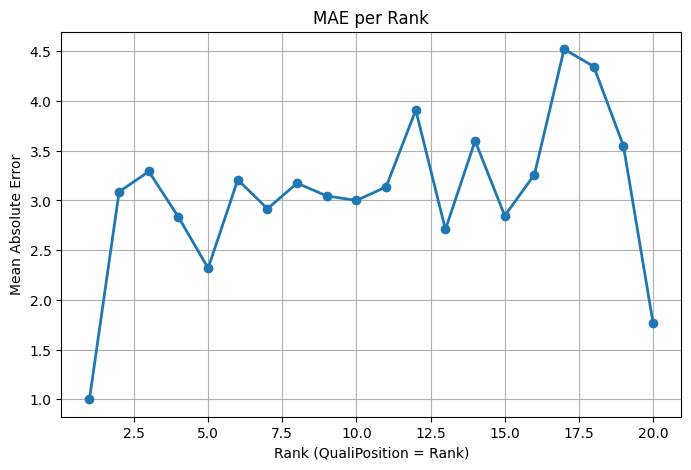

In [1052]:
mae_values = []

for rank in range(1, 21):
    results_top_rank = results[results['QualiPosition'] == rank]
    
    # Compute global RMSE for this rank
    global_mae = MAE(results_top_rank['QualiPosition'], results_top_rank['PredictionRank'])
    mae_values.append(global_mae)

# Create a DataFrame for plotting
mae_df = pd.DataFrame({
    'Rank Cutoff': range(1, 21),
    'MAE': mae_values
})
print(mae_df)
# Plot the results
plt.figure(figsize=(8, 5))
plt.plot(mae_df['Rank Cutoff'], mae_df['MAE'], marker='o', linestyle='-', linewidth=2)
plt.title('MAE per Rank')
plt.xlabel('Rank (QualiPosition = Rank)')
plt.ylabel('Mean Absolute Error')
plt.grid(True)
plt.show()
# pred = results_top_rank[['QualiPosition', 'PredictionRank']]
# rmse = MSE(results_top_rank['QualiPosition'], results_top_rank['PredictionRank'])
# print(rmse)
# pred.head()

## MAE per Driver


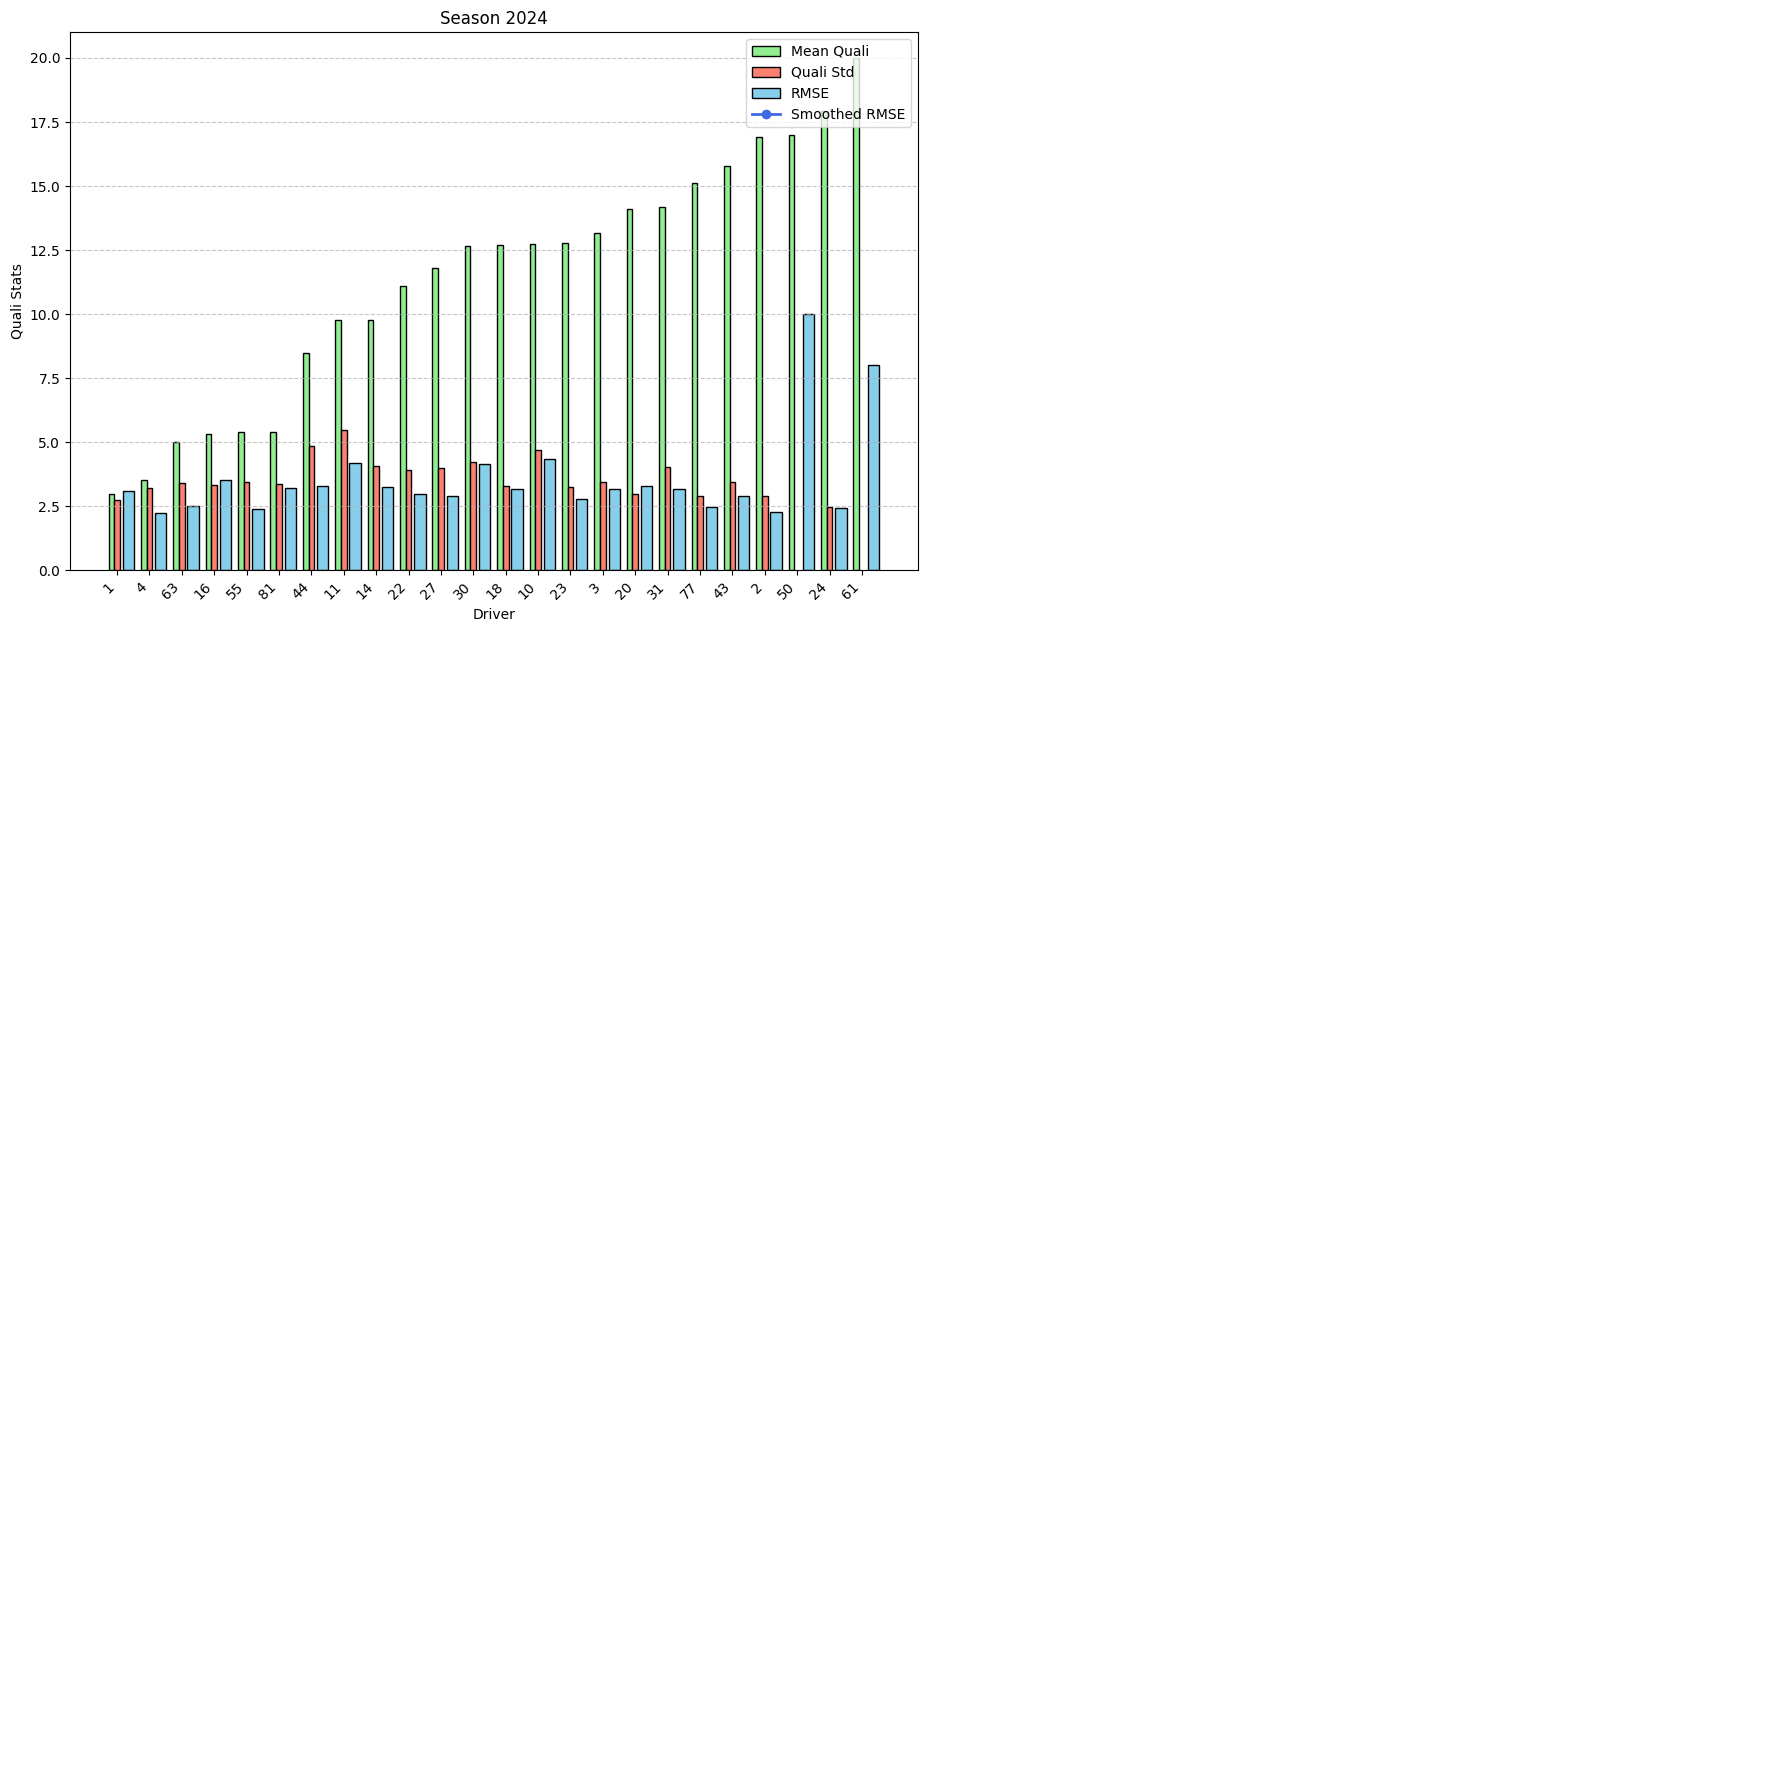

In [1053]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error as MSE
import numpy as np

# Loop through each season
seasons = results.index.get_level_values('Season').unique()

# Create 2x3 subplot grid
fig, axes = plt.subplots(3, 2, figsize=(18, 18))
axes = axes.flatten()  # Flatten for easy indexing

for i, season in enumerate(seasons):
    ax1 = axes[i]
    season_data = results[results.index.get_level_values('Season') == season]
    unique_drivers = season_data.index.get_level_values('DriverNumber').unique()

    rmse_values = []
    mean_quali = []
    std_quali = []

    # Compute per-driver metrics
    for driver in unique_drivers:
        results_by_driver = season_data[season_data.index.get_level_values('DriverNumber') == driver]
        y_true = results_by_driver['QualiPosition'].astype(float)
        y_pred = results_by_driver['PredictionRank'].astype(float)
        
        global_rmse = MAE(y_true, y_pred)
        rmse_values.append(global_rmse)
        mean_quali.append(y_true.mean())
        std_quali.append(y_true.std())

    # Build DataFrame
    rmse_df = pd.DataFrame({
        'Driver': unique_drivers,
        'RMSE': rmse_values,
        'MeanQuali': mean_quali,
        'StdQuali': std_quali
    }).sort_values(by='MeanQuali', ascending=True).reset_index(drop=True)

    # Smooth the RMSE line

    # X positions
    x = np.arange(len(rmse_df))
    width = 0.35

    # Bars for mean & std
    ax1.bar(x - width/2, rmse_df['MeanQuali'], width/2, label='Mean Quali', color='lightgreen', edgecolor='black')
    ax1.bar(x, rmse_df['StdQuali'], width/2, label='Quali Std', color='salmon', edgecolor='black')
    ax1.bar(x + width, rmse_df['RMSE'], width, label='RMSE', color='skyblue', edgecolor='black')
    ax1.set_xlabel('Driver', fontsize=10)
    ax1.set_ylabel('Quali Stats', fontsize=10, color='black')


    # Common settings
    ax1.set_xticks(x)
    ax1.set_xticklabels(rmse_df['Driver'], rotation=45, ha='right')
    ax1.set_title(f'Season {season}', fontsize=12)
    ax1.grid(axis='y', linestyle='--', alpha=0.7)

    # Combined legend
    bars_legend = ax1.get_legend_handles_labels()
    line_legend = ax2.get_legend_handles_labels()
    ax1.legend(bars_legend[0] + line_legend[0], bars_legend[1] + line_legend[1], loc='upper right')

# Hide any unused subplots
for j in range(len(seasons), 6):
    axes[j].axis('off')

plt.tight_layout()
plt.show()


In [1054]:
print('% that are the correct position exactly')
print(len(results[results['PredictionRank'] == results['QualiPosition']])/len(results))

% that are the correct position exactly
0.15250544662309368


In [1055]:
rmse = MAE(results['QualiPosition'], results['PredictionRank'])
print(rmse)
pred = results[['QualiPosition', 'PredictionRank']]
pred

3.0893246187363834


QualiPosition  PredictionRank
RoundNumber DriverNumber Season                               
1           1            2024              1.0             3.0
            11           2024              5.0             8.0
            55           2024              4.0             1.0
            16           2024              2.0             4.0
            63           2024              3.0             5.0
...                                        ...             ...
24          20           2024             15.0             8.0
            30           2024             12.0            17.0
            77           2024              9.0            13.0
            43           2024             19.0            20.0
            11           2024             10.0             9.0

[459 rows x 2 columns]

In [1056]:
# Compute RMSE per event (replace 'Event' with your actual column name)
rmse_per_event = results.groupby(['RoundNumber', 'Season']).apply(
    lambda df: MAE(df['QualiPosition'], df['PredictionRank'])
).reset_index(name='RMSE')
rmse_per_event= rmse_per_event.sort_values('RMSE')
print(rmse_per_event)

# Optional: if you still want the global RMSE across all data
global_rmse = MAE(results['QualiPosition'], results['PredictionRank'])
print(f"Global RMSE: {global_rmse:.3f}")

# Preview just the prediction columns
pred = results[['QualiPosition', 'PredictionRank']]
pred.head()

    RoundNumber  Season      RMSE
16           17    2024  1.666667
1             2    2024  1.777778
6             7    2024  2.000000
0             1    2024  2.100000
15           16    2024  2.100000
10           11    2024  2.100000
9            10    2024  2.200000
17           18    2024  2.300000
2             3    2024  2.611111
11           12    2024  2.736842
21           22    2024  2.800000
12           13    2024  3.000000
18           19    2024  3.000000
7             8    2024  3.200000
5             6    2024  3.300000
4             5    2024  3.300000
22           23    2024  3.500000
13           14    2024  3.684211
3             4    2024  3.916667
23           24    2024  4.100000
19           20    2024  4.157895
8             9    2024  4.400000
14           15    2024  4.529412
20           21    2024  5.900000
Global RMSE: 3.089


QualiPosition  PredictionRank
RoundNumber DriverNumber Season                               
1           1            2024              1.0             3.0
            11           2024              5.0             8.0
            55           2024              4.0             1.0
            16           2024              2.0             4.0
            63           2024              3.0             5.0

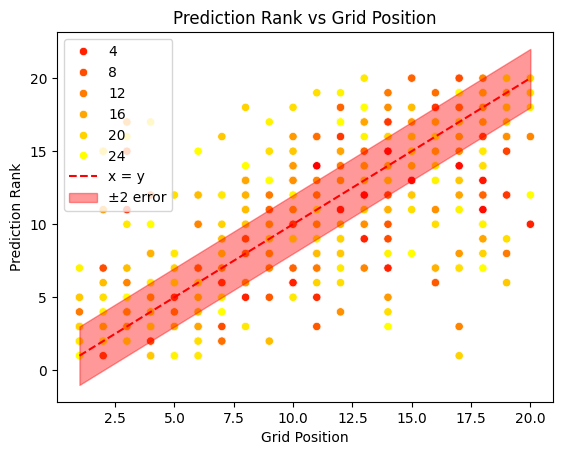

53.16% of predictions are within ±2 of x = y


In [1057]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Scatter plot
ytor = LinearSegmentedColormap.from_list("red_yellow", ["red", "yellow"])
sns.scatterplot(x=results['QualiPosition'], y=results['PredictionRank'], hue=results.index.get_level_values('RoundNumber'), palette=ytor)

# Define x values
x_vals = np.linspace(results['QualiPosition'].min(), results['QualiPosition'].max(), 100)

# Plot y = x line
plt.plot(x_vals, x_vals, color='red', linestyle='--', label='x = y')

# Add ±2 error area
plt.fill_between(x_vals, x_vals - 2, x_vals + 2, color='red', alpha=0.4, label='±2 error')

plt.xlabel('Grid Position')
plt.ylabel('Prediction Rank')
plt.title('Prediction Rank vs Grid Position')
plt.legend()
plt.show()

# Count points inside ±2 of y=x
inside_error = ((results['PredictionRank'] >= results['QualiPosition'] - 2) &
                (results['PredictionRank'] <= results['QualiPosition'] + 2))

percentage_inside = inside_error.mean() * 100  # mean() gives fraction of True values
print(f"{percentage_inside:.2f}% of predictions are within ±2 of x = y")



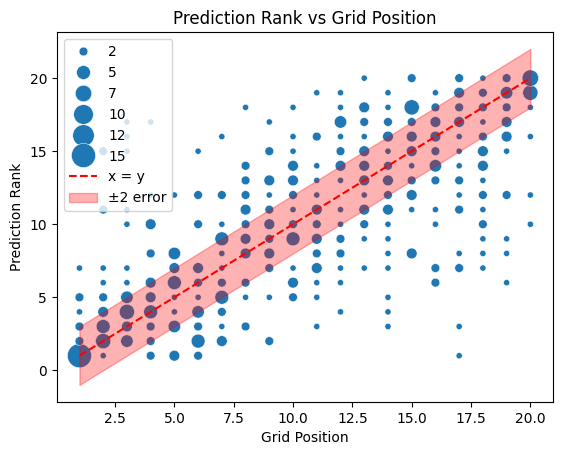

53.16% of predictions are within ±2 of x = y


In [1058]:
df = results.reset_index()

# Group by coordinate pairs and count occurrences
counts = (
    df.groupby(['QualiPosition', 'PredictionRank'], as_index=False)
      .agg(Count=('RoundNumber', 'size'),
           Season=('Season', 'first'))
)

# Scatter plot with point size representing count
sns.scatterplot(
    data=counts,
    x='QualiPosition',
    y='PredictionRank',
    size='Count',
    sizes=(20, 300),
    legend=True
)

# Add reference line y = x
x_vals = np.linspace(df['QualiPosition'].min(), df['QualiPosition'].max(), 100)
plt.plot(x_vals, x_vals, color='red', linestyle='--', label='x = y')

# Add ±2 error band
plt.fill_between(x_vals, x_vals - 2, x_vals + 2, color='red', alpha=0.3, label='±2 error')

plt.xlabel('Grid Position')
plt.ylabel('Prediction Rank')
plt.title('Prediction Rank vs Grid Position')
plt.legend()
plt.show()

# Compute % of predictions within ±2 of y = x
inside_error = (
    (df['PredictionRank'] >= df['QualiPosition'] - 2) &
    (df['PredictionRank'] <= df['QualiPosition'] + 2)
)
percentage_inside = inside_error.mean() * 100

print(f"{percentage_inside:.2f}% of predictions are within ±2 of x = y")

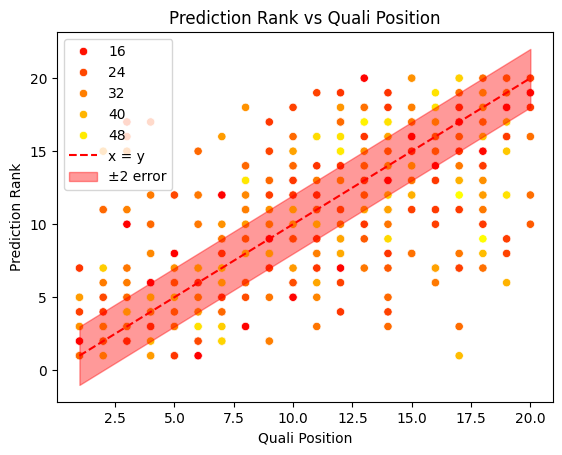

53.16% of predictions are within ±2 of x = y


In [1059]:
# Scatter plot

ytor = LinearSegmentedColormap.from_list("red_yellow", ["red", "yellow"])
sns.scatterplot(x=results['QualiPosition'], y=results['PredictionRank'], hue=results['Quali_TrackTemp'], palette=ytor)
# Define x values
x_vals = np.linspace(results['QualiPosition'].min(), results['QualiPosition'].max(), 100)

# Plot y = x line
plt.plot(x_vals, x_vals, color='red', linestyle='--', label='x = y')

# Add ±2 error area
plt.fill_between(x_vals, x_vals - 2, x_vals + 2, color='red', alpha=0.4, label='±2 error')

plt.xlabel('Quali Position')
plt.ylabel('Prediction Rank')
plt.title('Prediction Rank vs Quali Position')
plt.legend()
plt.show()

# Count points inside ±2 of y=x
inside_error = ((results['PredictionRank'] >= results['QualiPosition'] - 2) &
                (results['PredictionRank'] <= results['QualiPosition'] + 2))

percentage_inside = inside_error.mean() * 100  # mean() gives fraction of True values
print(f"{percentage_inside:.2f}% of predictions are within ±2 of x = y")

